In [26]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import math
import pandas as pd
from gymnasium import wrappers
from collections import deque
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [27]:
#Parameters
N = 100 #number
X_min = 0 #meters
X_max = 200 #meters
Y_min = 0 #meters
Y_max = 200 #meters
O = 20 #number
R_obstacles_max = 10 #meters
Safe_radius = 2 #meters
Cluster_radius = 10 #meters
H = 50 #meters
E_wake = 0.1 #Watt/s
Comm_radius = 10 #meters
Wake_radius = 30 #meters
B = 500 * 10**6 # hertz , available channel bandwidth
beta_o = 31.62 # Watts, path loss at reference distance
rho_m = 0.1 # Watts, transmitting power of a CH
sigma = 10**-13 # Watts , noise power
alpha = 2 # path loss exponent
V_max = 10 #m/s
V_min = 5 #m/s
E_start_UAV = 799200 #Joules
E_hover = 100 #Watt
U_tip = 200 #m/s
v_o = 10 # m/s , mean rotor induced velocity in the hovering state
rho = 1.225 # kg/m^3, air density
delta = 0.202 # rotor area
d_o = 0.1 # fusealage drag ratio , dimensionless
s = 0.1 # rotor solidity , dimensionless
P_o = 0.7 # blade profile power coefficient , dimensionless
P_i = 0.2 # induced power coefficient in the hovering state 
P_h = 100 #Watt, power required for hovering
D_max = 10 # meters
D_min = 1 # meters
E_IoTD_start = 1000000 #Joules
Distance_O_penalty = 1000000
Distance_multiplier = 0.01
h_reward = 100000

In [28]:
import pandas as pd 
from collections import deque
import gymnasium as gym

import os 
import numpy as np
from random import sample
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import torch.multiprocessing as mp
from torch.distributions import Categorical,Normal,MultivariateNormal
from multiprocessing.pool import Pool
import random
from rltorch.network import BaseNetwork
import torch
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defining functions

In [29]:
import random
from math import sqrt

def calculate_distance(coord1, coord2):
    distance = sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)
    return distance

def calculate_UAV_CH_distance(P_t,P_m):
    distance = sqrt((P_t[0] - P_m[0])**2 + (P_t[1] - P_m[1])**2 + P_t[2]**2)
    return distance

def calculate_power_gain_UAV_CH(beta_o,P_t,P_m):
    distance = calculate_UAV_CH_distance(P_t,P_m)
    power_gain = beta_o/(distance**2)
    return power_gain

def calculate_UAV_CH_transmission_rate(B, P_t, P_m, beta_o, sigma, rho_m):
    power_gain = calculate_power_gain_UAV_CH(beta_o, P_t, P_m)
    transmission_rate = B * np.log2(1 + (rho_m * power_gain)/(sigma**2))
    return transmission_rate

def calculate_UAV_CH_Upload_time(B, P_t, P_m, beta_o, sigma, rho_m, I_m):
    transmission_rate = calculate_UAV_CH_transmission_rate(B, P_t, P_m, beta_o, B , sigma, rho_m)
    upload_time = I_m/transmission_rate
    return upload_time

def calculate_CH_IoTD_distance(P_m, P_n):
    distance = sqrt((P_m[0] - P_n[0])**2 + (P_m[1] - P_n[1])**2)
    return distance

def calculate_CH_IOTD_transmission_rate(B, P_m, P_n, beta_m,rho_n,alpha , rho_i):
    distance = calculate_CH_IoTD_distance(P_m, P_n)
    power_gain = beta_m/(distance**alpha)
    transmission_rate = B * np.log2(1 + (rho_i * power_gain)/(rho_n))
    return transmission_rate

def calculate_UAV_Obstacle_distance(P_t,L_o):
    distance = sqrt((P_t[0]-L_o[0])**2 + (P_t[1]-L_o[1])**2) - L_o[2]
    return distance

def calculate_UAV_travel_energy_per_second(P_o,v_t,U_tip,P_i,v_o,d_o,rho,s,delta):
    energy_per_second = P_o*(1+3*(v_t**2)/(U_tip**2)) + P_i*v_o/v_t + d_o*rho*s*delta*(v_t**3)/2
    return energy_per_second

def maximum_minimum_distance_clustering(nodes, cluster_radius):
    cluster_heads = []
    remaining_nodes = nodes.copy()

    cluster_heads.append(remaining_nodes.pop(0))

    while remaining_nodes:
        max_min_distance = 0
        max_min_distance_node = None
        for node in remaining_nodes:
            min_distance = min(calculate_distance(node, ch) for ch in cluster_heads)
            if min_distance > max_min_distance and min_distance > cluster_radius:
                max_min_distance = min_distance
                max_min_distance_node = node
        if max_min_distance_node is None:
            break
        cluster_heads.append(max_min_distance_node)
        remaining_nodes.remove(max_min_distance_node)

    clusters = {ch: [] for ch in cluster_heads}
    for node in remaining_nodes:
        nearest_ch = min(cluster_heads, key=lambda ch: calculate_distance(node, ch))
        clusters[nearest_ch].append(node)

    return clusters

def generate_IoTD_coordinates_outside_obstacles(num_coordinates, Obstacle_coordinates):
    coordinates = []
    xmin = X_min
    xmax = X_max
    ymin = Y_min
    ymax = Y_max
    for i in range(num_coordinates):
        x = random.uniform(xmin, xmax)
        y = random.uniform(ymin, ymax)
        new_coord = (x, y)
        if not any(calculate_distance(new_coord, obstacle) <= obstacle[2] + Safe_radius for obstacle in Obstacle_coordinates):
            coordinates.append(new_coord)
    
    return coordinates

    

def generate_Obstacle_coordinates(num_coordinates):
    coordinates = []
    xmin = X_min
    xmax = X_max
    ymin = Y_min
    ymax = Y_max
    for i in range(num_coordinates):
        x = random.uniform(xmin, xmax)
        y = random.uniform(ymin, ymax)
        r = random.uniform(0, R_obstacles_max)
        new_coord = (x, y, r)
        coordinates.append(new_coord)
    
    return coordinates


Generating the world


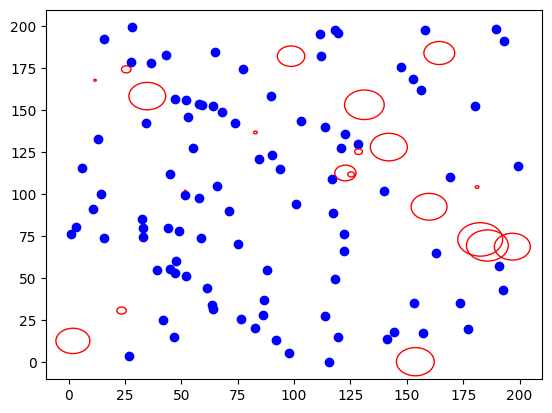

In [30]:
O_obstacles = generate_Obstacle_coordinates(O)
N = generate_IoTD_coordinates_outside_obstacles(N, O_obstacles)
import matplotlib.pyplot as plt

# Plot IoTDs
for coord in N:
    plt.scatter(coord[0], coord[1], color='blue', label='IoTD')
    
# Plot Obstacles
for obstacle in O_obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', fill=False)
    plt.gca().add_patch(circle)

# Set plot limits
plt.xlim(X_min - 10, X_max + 10)
plt.ylim(Y_min - 10, Y_max + 10)

# Add legend
# plt.legend()

# Show the plot
plt.show()


Clustering


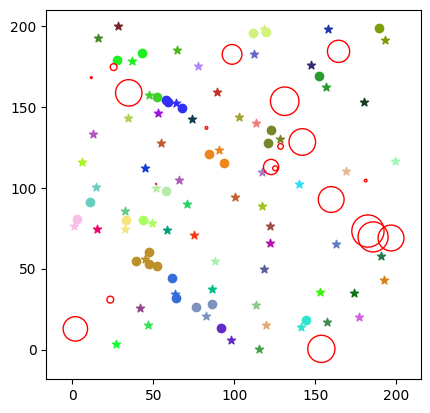

66


In [31]:
Clusters = maximum_minimum_distance_clustering(N, Cluster_radius)

M = []

for cluster_head, cluster_nodes in Clusters.items():
    M.append(cluster_head)

x,y=[node[0] for node in Clusters.keys()],[node[1] for node in Clusters.keys()]
for i in Clusters.keys():
    color=(random.choice(range(256))/255,
           random.choice(range(256))/255,
           random.choice(range(256))/255)
    plt.scatter(i[0],i[1],color=color,marker='*')
    for j in Clusters[i]:
        plt.scatter(j[0],j[1],color=color)
for obstacle in O_obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', fill=False)
    plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.show()
print(len(x))

Data = []

for cluster_head , cluster_nodes in Clusters.items():
    Data_cluster = 0
    for node in cluster_nodes:
        Data_cluster += random.randint(1, 10)
    Data.append(Data_cluster)





In [32]:
#debugging

Environment 

In [71]:
class Single_Agent_UAV(gym.Env):
    def __init__(self, initial_UAV_state = None):
        super(Single_Agent_UAV, self).__init__()

        self.obstacle_count = len(O_obstacles)
        self.CH_count = len(M)
        self.v_max = V_max
        self.AOI = [0 for i in range(self.CH_count)]
        self.data = Data
        self.UAV_state = [100,0,H] # initial UAV state
        self.UAV_energy = E_start_UAV
        self.distance_from_obstacles = [calculate_UAV_Obstacle_distance(self.UAV_state, obstacle) for obstacle in O_obstacles]
        self.distance_from_CH = [calculate_distance(self.UAV_state, CH) for CH in M]
        self.possible_to_wake = [distance <= Wake_radius for distance in self.distance_from_CH]
        self.energy_IoTDs = [0 for i in range(self.CH_count)]
        self.covered_IoTDs = [0 for i in range(self.CH_count)]
        self.current_energy = E_start_UAV
        self.timesteps_in_episode = 0
        self.done = False
        self.max_episode_steps = 1000
        # defining the action space
        # self.action_space = spaces.Box(low = np.array([V_min, D_min, -180]), high = np.array([V_max, D_max, 180]), dtype = np.float32)
        
        # defining the observation space - the state of the UAV (3), the energy of the UAV (1), the AOI of all the CHs (m), 
        # the data of all the CHs (m), coverage of the CHs (m) , energy of all the CHs (m),distance of the UAV from all the obstacles (o),

        X = 4 + 4 * self.CH_count + self.obstacle_count

        # plotting parameters
        self.plotting_boundary_buffer = 5.
        self.UAV_coverage_circle_color = 'lavender'
        self.UAV_path_color = 'green'
        obh = []
        obl = []

        #appending UAV positions in highs and lows of the observation space
        obh.append(X_max)
        obh.append(Y_max)
        obh.append(H)
        obl.append(X_min)
        obl.append(Y_min)
        obl.append(H)

        # appending the UAV energy in highs and lows of the observation space
        obh.append(E_start_UAV)
        obl.append(0)

        #appending the AOI of all the CHs in highs and lows of the observation space
        for i in range(self.CH_count):
            obh.append(float('inf'))
            obl.append(0)
        
        #appending the data of all the CHs in highs and lows of the observation space
        for i in range(self.CH_count):
            obh.append(self.data[i])
            obl.append(0)
        
        #appending the coverage of all the CHs in highs and lows of the observation space
        for i in range(self.CH_count):
            obh.append(1)
            obl.append(0)
        
        #appending the energy of all the CHs in highs and lows of the observation space
        for i in range(self.CH_count):
            obh.append(E_IoTD_start)
            obl.append(0)

        #appending the distance of the UAV from all the obstacles in highs and lows of the observation space
        for i in range(self.obstacle_count):
            obh.append(float('inf'))
            obl.append(0)

        high = np.array(obh, dtype=np.float32)
        low = np.array(obl, dtype=np.float32)
        
        self.observation_space = spaces.Box(low, high)
        #self.action_space = spaces.Box(low=low1, high=high1, dtype=np.float32)
        # action space consists of the velocity of the UAV , the step size of the UAv and the angle of the UAV
        # remember to clip the action space while taking the step in the environment
        self.action_space = spaces.Box(-1, 1, (3,), dtype=np.float32)

    def reset(self):
        self.UAV_state = [100,0,H]
        self.current_energy = E_start_UAV
        self.AOI = [0 for i in range(self.CH_count)]
        self.data = Data
        self.done = False
        self.covered_IoTDs = [0 for i in range(self.CH_count)]
        self.distance_from_CH = [calculate_distance(self.UAV_state, CH) for CH in M]
        self.distance_from_obstacles = [calculate_UAV_Obstacle_distance(self.UAV_state, obstacle) for obstacle in O_obstacles]
        self.possible_to_wake = [0 for i in range(self.CH_count)]
        self.energy_IoTDs = [0 for i in range(self.CH_count)]
        self.UAV_energy = E_start_UAV
        self.covered_IoTDs = [0 for i in range(self.CH_count)]
        self.current_energy = E_start_UAV
        self.timesteps_in_episode = 0
        self.done = False
        obs = []
        obs.append(self.UAV_state[0])
        obs.append(self.UAV_state[1])
        obs.append(self.UAV_state[2])
        obs.append(self.current_energy)
        for i in range(self.CH_count):
            obs.append(self.AOI[i])
        for i in range(self.CH_count):
            obs.append(self.data[i])
        for i in range(self.CH_count):
            obs.append(self.covered_IoTDs[i])
        for i in range(self.CH_count):
            obs.append(self.energy_IoTDs[i])
        for i in range(self.obstacle_count):
            obs.append(self.distance_from_obstacles[i])

        return np.array(obs)
    
    
#     def get_count_of_UEs_covered(self):
#         profit = 0
#         ground_UAV_state = self.current_state[:2]
#         for i in range(self.UE_count):
#             if(math.dist(self.UE_positions[i], ground_UAV_state)<=self.C_max_t):
#                 if(self.visited[i]==0):
#                     profit = profit + 100
#                     self.visited[i] =1
#                 else:
#                     profit = profit 
#             else:
#                 if(self.visited[i]==0):
#                     profit = profit -1
# #         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
# #         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
# #         M_t = rho_array.sum()
#         return profit


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''
        
        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 1, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(**kwargs)


    def step(self, action: np.ndarray):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''

        '''
        While taking a step , we may encounter a situation where the IoTD is ready to give data to the UAV
        in that case , we take the data , calculate the time and then give the reward as per , continuing with our step
        '''

        # terms used in the reward function
        # 1. AOI
        # 2. Energy of the UAV
        # 3. Energy consumed by the IoTDs
        # 4. Distance from the obstacles
        # 5. Number of IoTDs covered
        
        # action = action.numpy().flatten()
#         err_msg = f"{action!r} ({type(action)}) invalid"
#         assert self.action_space.contains(action), err_msg
#         assert self.current_state is not None, "Call reset before using step method."
        
        self.timesteps_in_episode += 1

        # getting the current position of the UAV
        prev_UAV_state = self.UAV_state
        velocity = (action[0]+1.5)*5 + 2.5  # velocity of the UAV
        step_size = (action[1]+1.5)*5 + 2.5  # step size of the UAV
        angle = (action[2])*np.pi  # angle of the UAV


        # moving the UAV
        action, inside_bounds = self.move(step_size, angle)

        if inside_bounds:
            x_cur = action[0]
            y_cur = action[1]
            self.UAV_state = [x_cur, y_cur, H]
            # UAV remains in its current position

        # calculating the time for which the UAV flew
        time_flew = calculate_distance(prev_UAV_state, self.UAV_state)/velocity

        # Calculating the energy used by the UAV in the current step
        energy_used = time_flew * calculate_UAV_travel_energy_per_second(P_o, velocity, U_tip, P_i, v_o, d_o, rho, s, delta)

        # updating the energy of the UAV
        self.current_energy -= energy_used

        # updating the distance of the UAV from the obstacles
        self.distance_from_obstacles = [calculate_UAV_Obstacle_distance(self.UAV_state, obstacle) for obstacle in O_obstacles]

        # updating the distance of the UAV from the CHs
        self.distance_from_CH = [calculate_distance(self.UAV_state, CH) for CH in M]

        # calculating the possible CHs to wake up
        self.possible_to_wake = [distance <= Wake_radius for distance in self.distance_from_CH]

        time_hover = 0

        last_covered = self.covered_IoTDs.copy()

        h = 0

        # calculating the served IoTDs
        for i in range(self.CH_count):
            if self.distance_from_CH[i] <= Comm_radius and self.covered_IoTDs[i] == 0:
                self.covered_IoTDs[i] = 1
                R = calculate_UAV_CH_transmission_rate(B, self.UAV_state, M[i], beta_o, sigma, rho_m)
                time_hover += self.data[i]/R
                self.energy_IoTDs[i] += rho_m * self.data[i]/R
                self.data[i] = 0
                h += 1

        # calculating the energy used by the UAV in hovering
        energy_hover = time_hover * P_h

        # updating the energy of the UAV
        self.current_energy -= energy_hover

        # adding the wake energy of sensors to each IoTD
        for i in range(self.CH_count):
            self.energy_IoTDs[i] += E_wake * (time_flew + time_hover)

        #calculating the AOI of the CHs
        for i in range(self.CH_count):
            if self.covered_IoTDs[i] == 0:
                self.AOI[i] += time_flew + time_hover
            else :
                self.AOI[i] = 0

        

        # caclulating the average AOI
        avg_AOI = sum(self.AOI)/self.CH_count
        
        # Energy of the UAV used till the time block:
        energy = E_start_UAV - self.current_energy

        # Average energy used of all the IoTDs:
        avg_energy_IoTDs = sum(self.energy_IoTDs)/self.CH_count

        # calculating the distance of the UAV from the obstacles
        self.distance_from_obstacles = [calculate_UAV_Obstacle_distance(self.UAV_state, obstacle) for obstacle in O_obstacles]

        #calculating the distance penalty of the UAV from the obstacles:
        distance_penalty = 0
        for i in range(self.obstacle_count):
            if self.distance_from_obstacles[i] <= Safe_radius:
                distance_penalty += Distance_O_penalty
            else :
                distance_penalty += Distance_multiplier * self.distance_from_obstacles[i]

        
        
        # calculating the reward
        reward = - 0.1 * avg_AOI - 0.5 * avg_energy_IoTDs - 0.01 * distance_penalty  + 10 * h*h_reward # + 0.1 * energy


        self.is_done()
        obs = []
        obs.append(self.UAV_state[0])
        obs.append(self.UAV_state[1])
        obs.append(self.UAV_state[2])
        obs.append(self.current_energy)
        for i in range(self.CH_count):
            obs.append(self.AOI[i])
        
        for i in range(self.CH_count):
            obs.append(self.data[i])
        
        for i in range(self.CH_count):
            obs.append(self.covered_IoTDs[i])
        
        for i in range(self.CH_count):
            obs.append(self.energy_IoTDs[i])
        
        for i in range(self.obstacle_count):
            obs.append(self.distance_from_obstacles[i])
        

        
        return obs, reward, self.done, None
    

    def move(self, step_size, angle):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''
        x_next = self.UAV_state[0] + (math.cos(angle) * step_size)
        y_next = self.UAV_state[1] + (math.sin(angle) * step_size)
        action = np.array([x_next, y_next])
        if((x_next < 0) or (x_next > X_max) or (y_next < 0) or (y_next > Y_max)):
            # UAV REMAINS IN ITS CURRENT POSITION
            return np.array([step_size,angle ]), False
        
        return action, True


    def is_done(self):
        '''
        Helper function to check if episode needs to be terminated
        '''
        if(sum(self.covered_IoTDs)>=self.CH_count*0.8):
            print(sum(self.covered_IoTDs))
            self.done = True
        elif(self.timesteps_in_episode >= self.max_episode_steps):
            self.done = True

        return

    
    def render_position_plot(self, UAV_positions_list):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''
        pos = UAV_positions_list

        # plotting all the IoTDs , clusters and obstacles
        
        for i in range(self.CH_count):
            if self.covered_IoTDs[i] == 1:
                plt.scatter(M[i][0], M[i][1], color='green', label='CH')
            else:
                plt.scatter(M[i][0], M[i][1], color='red', label='CH')
    
        
        for obstacle in O_obstacles:
            circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', fill=False)
            plt.gca().add_patch(circle)

        # plotting the UAV path
        plt.plot(pos[:, 0], pos[:, 1], color='green', label='UAV Path')
        plt.scatter(pos[-1, 0], pos[-1, 1], marker='x' ,color='blue', label='UAV ending position')
        plt.gca().set_aspect('equal')
        # plt.legend()

      
        plt.show()
        

[ 0.9815803   0.41235065 -0.30232146]
[100, 0, 50, 799200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

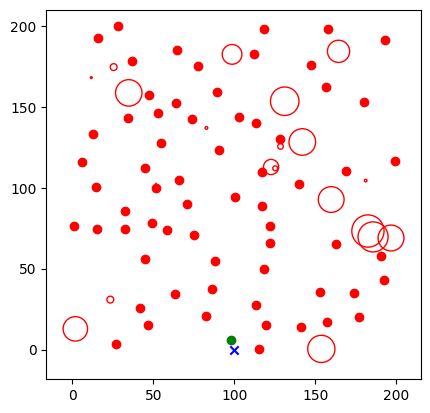

In [72]:
env = Single_Agent_UAV()
state = env.reset()
UAV_positions_list = []
UAV_positions_list.append(state[:2])
a = env.action_space.sample()
print(a)
next_state, reward, done, _ = env.step(a)
print(next_state, reward)
UAV_positions_list.append(next_state[:2])
b = env.action_space.sample()
print(b)
next_state, reward, done, _ = env.step(b)
print(next_state, reward)
UAV_positions_list.append(next_state[:2])
UAV_positions_list = np.array(UAV_positions_list)
print("List",UAV_positions_list)
env.render_position_plot(UAV_positions_list = UAV_positions_list)

In [73]:
def update_params(optim, network, loss, grad_clip=None, retain_graph=False):
    optim.zero_grad()
    loss.backward(retain_graph=retain_graph)
    if grad_clip is not None:
        for p in network.modules():
            torch.nn.utils.clip_grad_norm_(p.parameters(), grad_clip)
    optim.step()


def soft_update(target, source, tau):
    for t, s in zip(target.parameters(), source.parameters()):
        t.data.copy_(t.data * (1.0 - tau) + s.data * tau)


def hard_update(target, source):
    target.load_state_dict(source.state_dict())


def grad_false(network):
    for param in network.parameters():
        param.requires_grad = False
        
class V(BaseNetwork):
    def __init__(self, num_inputs, num_actions=env.action_space.shape[0], hidden_units=[256, 256],
                 initializer='xavier'):
        super(V, self).__init__()

        self.value = nn.Sequential(
                            nn.Linear(num_inputs, 128),
                            nn.ReLU(),
                            nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Linear(128, 1))
    def forward(self, x):
        q = self.value(x)
        return q

In [74]:
class Actor(nn.Module):
    def __init__(self,num_in,numact):
        super(Actor,self).__init__()
        
        self.numact=numact
        self.lin1 = nn.Linear(num_in,100)
        self.lin2=nn.Linear(100,100)
        
        self.lin_out=nn.Linear(100,numact)
    def forward(self,state):
        y=T.tanh(self.lin1(state))
        y=T.tanh(self.lin2(y))
        y=T.tanh(self.lin_out(y))
        return y
    def set_std(self,new_action_std):
        self.action_var = torch.full((self.numact,), new_action_std * new_action_std)
        
        
    def get_action(self,state):
        
        means=self.forward(state)
        
        cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
        action_var = self.action_var.expand_as(means)
        dist = MultivariateNormal(means+1e-7, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action+1e-7)
        
        return action.detach(), action_logprob.detach()
    def get_entropy(self,state,action):
        means=self.forward(state)
        action_var = self.action_var.expand_as(means)
        cov_mat = torch.diag_embed(action_var)
      
        dist = MultivariateNormal(means+1e-7, cov_mat)

        action_logprobs = dist.log_prob(action+1e-7)
        dist_entropy = dist.entropy()
 
        
        return action_logprobs, dist_entropy

In [75]:
class Replaybuffer:
    def __init__(self):
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.dones=[]
        self.logprobs=[]
    def clear(self):
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.dones=[]
        self.logprobs=[]

In [76]:
class Agent:
    def __init__(self,envstr,alpha,beta,gamma,eps_clip,K_epochs,action_std_init,min_action_std,action_std_decay_rate):
        env =Single_Agent_UAV()
        self.act_dim=env.action_space.shape[0]
        self.state_dim=env.observation_space.shape[0]
#         print( self.act_dim)

        self.Actor=Actor(self.state_dim,self.act_dim).to(device)
        self.Actor_old=Actor(self.state_dim,self.act_dim).to(device)
        self.Actor_old.load_state_dict(self.Actor.state_dict())
        self.Value=V(env.observation_space.shape[0],1).to(device)
        self.gamma=gamma
        self.Replaybuffer=Replaybuffer()
        self.optimizer=T.optim.Adam([{'params': self.Actor.parameters(), 'lr': alpha},
                        {'params': self.Value.parameters(), 'lr': beta}])
        self.MseLoss=nn.MSELoss()
        self.grad_clip=1
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.action_std=action_std_init
        self.min_action_std=min_action_std
        self.action_std_decay_rate=action_std_decay_rate
        self.Actor.set_std(self.action_std)
        self.grad_clip=1
    def get_action(self,state):
   
        state=T.FloatTensor(np.array(state).reshape(-1,self.state_dim)).to(device)

   
        action,logprob=self.Actor.get_action(state)
        
        self.Replaybuffer.logprobs.append(logprob)
        self.Replaybuffer.states.append(state)
        self.Replaybuffer.actions.append(action)
        
        return action.detach().cpu().numpy()[0]
    def decay_std(self):
        self.action_std = self.action_std - self.action_std_decay_rate
        self.action_std = round(self.action_std, 4)
        if (self.action_std <= self.min_action_std):
            self.action_std = self.min_action_std
        
        self.Actor.set_std(self.action_std)
            
    def update(self):


        rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(self.Replaybuffer.rewards), reversed(self.Replaybuffer.dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            

        rewards = torch.FloatTensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.squeeze(torch.stack(self.Replaybuffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.Replaybuffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.Replaybuffer.logprobs, dim=0)).detach().to(device)


        
        for _ in range(self.K_epochs):
            
            values=self.Value(old_states)
  
            logprobs, dist_entropy = self.Actor.get_entropy(old_states, old_actions)

       
            state_values = torch.squeeze(values)
            
   
            ratios = torch.exp(logprobs - old_logprobs.detach())

  
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
           

            self.optimizer.zero_grad()
            loss.mean().backward()
            for p in self.Actor.modules():
                torch.nn.utils.clip_grad_norm_(p.parameters(), self.grad_clip)
            for p in self.Value.modules():
                torch.nn.utils.clip_grad_norm_(p.parameters(),self.grad_clip)
            self.optimizer.step()

        self.Actor_old.load_state_dict(self.Actor.state_dict())


        self.Replaybuffer.clear()

In [78]:
episodes = 40000   

       
action_std = 0.6                    
action_std_decay_rate = 0.05       
min_action_std = 0.1                

  
K_epochs = 30        

eps_clip = 0.2         
gamma = 0.95           
max_steps=1000
update=max_steps*4
overallsteps=1500000000
lr_actor = 0.0003  
lr_critic = 0.001      
string='Single_Agent_UAV'

In [79]:
agent=Agent(string,lr_actor,lr_critic,gamma,eps_clip,K_epochs,action_std,min_action_std,action_std_decay_rate)

In [80]:
env=Single_Agent_UAV()
step=0
rp=0
scores=[]
UAVPosList = []
while step<=overallsteps:
        interscore=0
            
        state = env.reset()
        done=False
        current_ep_reward = 0
    
        for j in range(max_steps):
            step+=1
            
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            interscore+=reward

            UAVPosList.append(state[:2])

            agent.Replaybuffer.rewards.append(reward)
            agent.Replaybuffer.dones.append(done)

            # update PPO agent
            if step % 4000 == 0:
                agent.update()


            if step % 100000 == 0:
                agent.decay_std()
            scores.append(interscore)

            #   env.render_position_plot(UAVPosList)
            
            if done:
                UAVPosList = []
                rp+=1
                if rp%40==0:
                    print(np.mean(scores[-100:]),step)
   
                break

15101878.072010664 40000
14266672.708418652 80000
8028956.5271222815 120000
9447401.73053552 160000
8501002.764965016 200000
12534307.587162511 240000
10907166.98583229 280000
7909161.631202495 320000
15810193.549884172 360000
21387366.330553662 400000
13920398.611138677 440000
18944187.878638864 480000
15988473.689537277 520000
11978247.654978227 560000
14970664.611213146 600000
13992233.921830356 640000
9989523.54869393 680000
14995470.263087526 720000
8965549.750342814 760000


KeyboardInterrupt: 

score -0.1 avg_score -0.1
score -0.3 avg_score -0.3
score 999999.5 avg_score 999999.5
score 999999.1 avg_score 999999.1
score 999998.7 avg_score 999998.7
score 1999998.2 avg_score 1999998.2
score 1999997.6 avg_score 1999997.6
score 1999997.0 avg_score 1999997.0
score 1999996.3 avg_score 1999996.3
score 1999995.5 avg_score 1999995.5
score 1999994.8 avg_score 1999994.8
score 1999994.1 avg_score 1999994.1
score 1999993.4 avg_score 1999993.4
score 1999992.7 avg_score 1999992.7
score 1999992.0 avg_score 1999992.0
score 1999991.2 avg_score 1999991.2
score 1999990.5 avg_score 1999990.5
score 1999989.8 avg_score 1999989.8
score 1999989.1 avg_score 1999989.1
score 1999988.4 avg_score 1999988.4
score 1999987.7 avg_score 1999987.7
score 1999986.9 avg_score 1999986.9
score 1999986.2 avg_score 1999986.2
score 1999985.5 avg_score 1999985.5
score 1999984.8 avg_score 1999984.8
score 1999984.1 avg_score 1999984.1
score 1999983.3 avg_score 1999983.3
score 1999982.6 avg_score 1999982.6
score 1999981.9 av

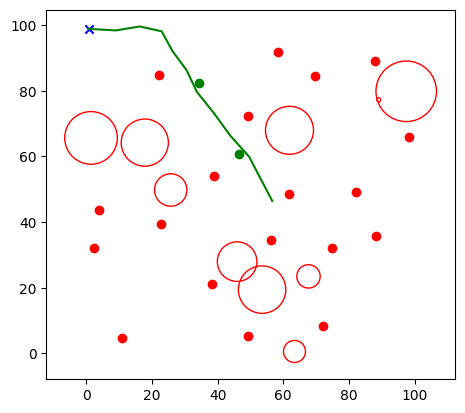

In [ ]:
state = env.reset()
done = False
score = 0
UAV_positions_list =[]
while not done:
    action = agent.get_action(state)
    state, reward, done, _ = env.step(action)
    score += reward
    UAV_positions_list.append([state[0],state[1]])

    print('score %.1f' % score, 'avg_score %.1f' % score)
UAV_positions_list = np.array(UAV_positions_list)
env.render_position_plot(UAV_positions_list = UAV_positions_list)